In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_fit()
coord_dict = {"fit": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

sigma: [1.41161381] scale: [7.33497171]
Creating df for fit
Optimal k is 3
Done


In [3]:
t_label = "fit"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,4.56190,6.84360,0.000000,coordinator,187489,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,-4.17850,-6.91490,16.300028,worker,187489,12,50,49,45,55,...,44,45,45,27,21,64,4,0,1,2
2,-1.26250,-2.25620,10.804166,worker,187489,1,50,53,52,55,...,48,45,34,91,29,178,0,0,1,2
3,-0.14588,-2.82470,10.753568,worker,187489,2,50,49,55,51,...,43,34,31,50,44,22,12,0,1,2
4,6.22700,-0.84394,7.865801,worker,187489,3,50,48,54,59,...,46,44,93,79,17,19,73,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,14.10200,-4.01350,14.453032,worker,187489,2,50,53,51,57,...,51,82,38,25,82,31,8,0,1,2
429,13.88500,-5.90200,15.791470,worker,187489,2,50,53,52,53,...,62,45,35,27,57,104,58,0,1,2
430,12.97500,-5.61380,15.032201,worker,187489,1,50,53,50,49,...,40,45,34,26,23,45,23,0,1,2
431,-8.41010,8.46420,13.072839,worker,187489,1,50,52,50,45,...,41,61,43,26,65,83,4,0,1,2


In [4]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 3088 Available: 21650


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

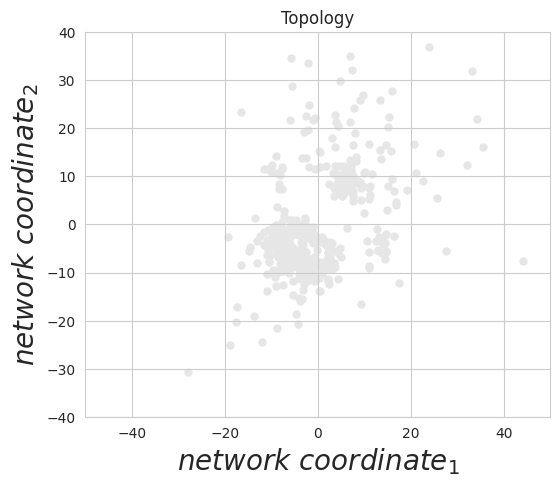

In [9]:
X_dim_def = [-50, 50]
Y_dim_def = [-40, 40]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=False, show_coordinator=False)

ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/fit/fit_ncs_plain.svg", bbox_inches="tight")

plt.show()

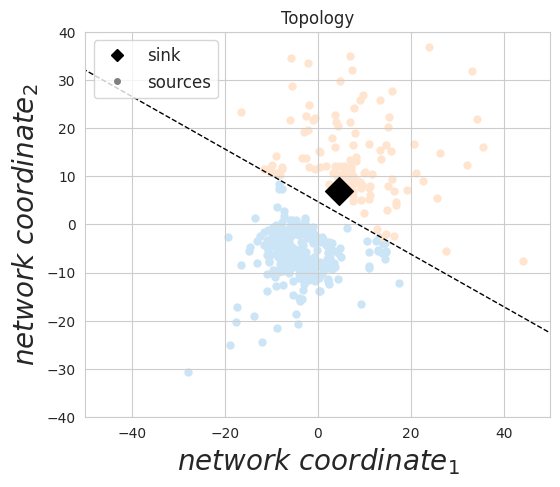

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1 = util.plot_topology(ax1, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

# plt.savefig("plots/fit/fit_ncs_colored.svg", bbox_inches="tight")

plt.show()

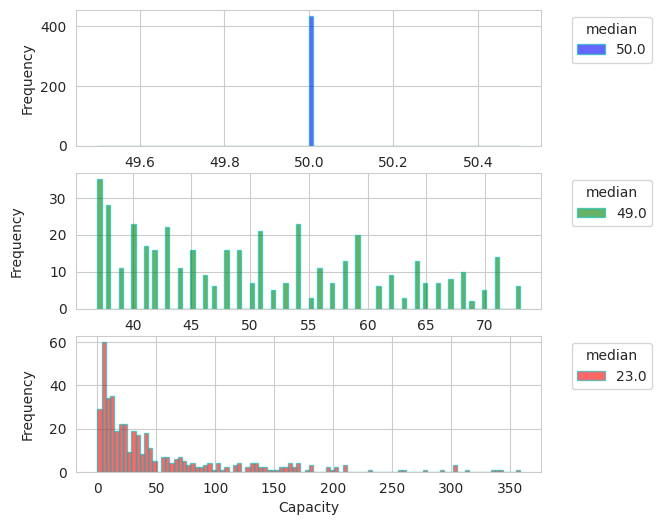

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

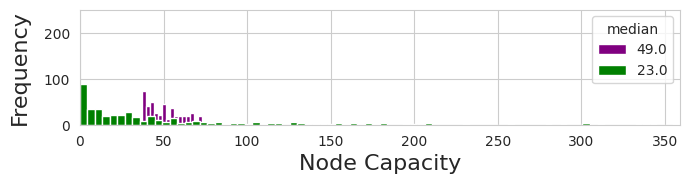

In [13]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/fit/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


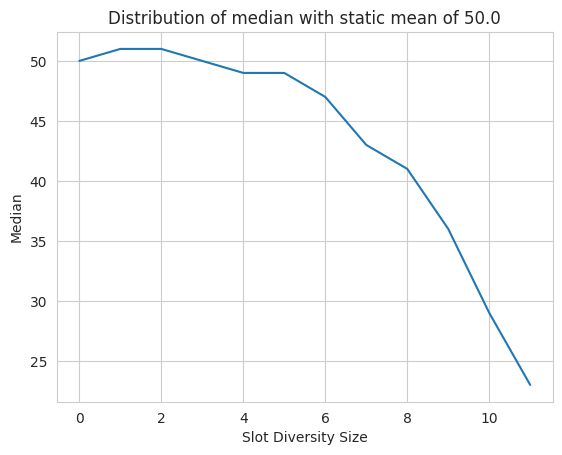

In [14]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [15]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

     latency_distribution  received_packets
0                0.000000             432.0
1               16.300028               0.0
2               10.804166               0.0
3               10.753568               0.0
4                7.865801               0.0
..                    ...               ...
428             14.453032               0.0
429             15.791470               0.0
430             15.032201               0.0
431             13.072839               0.0
432             14.977569               0.0

[433 rows x 2 columns]


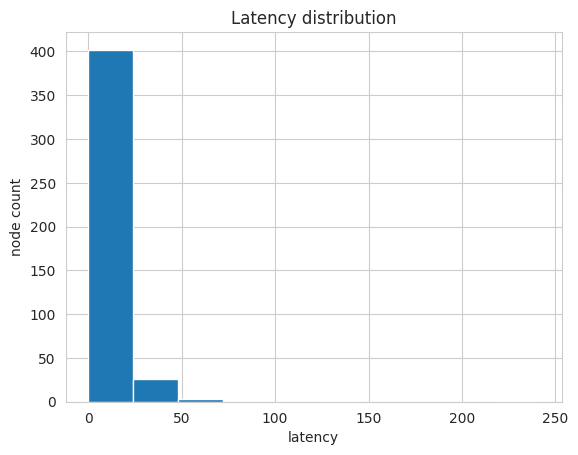

In [16]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [17]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 433 = 0.23095 %


### Experiment 1: LEACH Protocol

In [18]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1*device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  43
[293, 17, 220, 248, 296, 8, 106, 237, 417, 252, 422, 143, 335, 416, 83, 18, 267, 251, 168, 39, 128, 382, 185, 23, 216, 72, 309, 182, 196, 146, 424, 346, 135, 234, 90, 352, 156, 339, 186, 69, 394, 123, 226]


In [19]:
df_stats

,latency_distribution,received_packets
0,0.000000,43.0
1,18.655511,0.0
2,10.908605,0.0
3,10.503399,0.0
4,16.039567,0.0
...,...,...
428,13.953163,0.0
429,16.049867,0.0
430,17.049867,0.0
431,24.091816,0.0


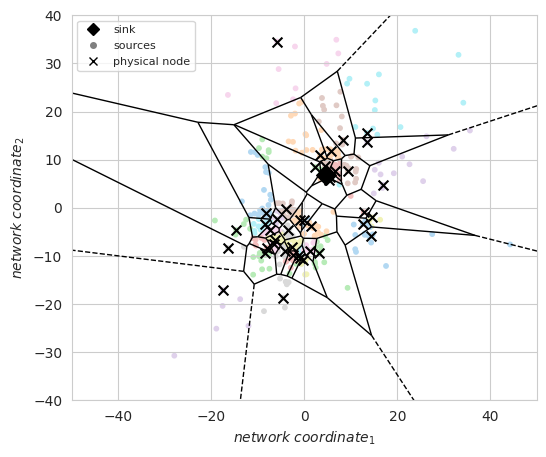

In [20]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/fit/leach.svg")
plt.show()

count    433.000000
mean      16.812790
std       15.609759
min        0.000000
25%       11.503399
50%       16.172295
75%       18.999351
max      253.604529
Name: latency_distribution, dtype: float64


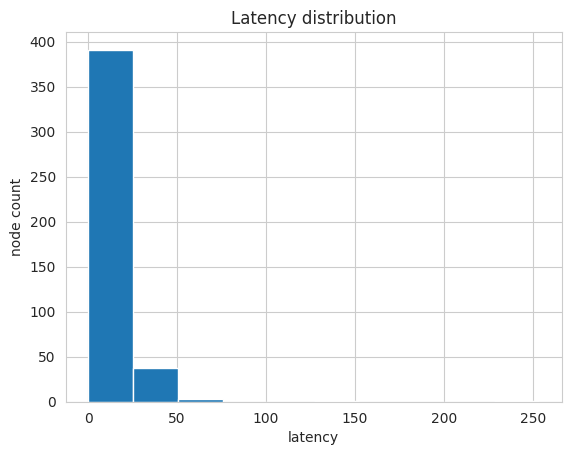

In [21]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [22]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [28]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.full_like(X, fill_value=np.nan)
mean_lat_values = np.full_like(X, fill_value=np.nan)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  432 Load: 3088
--------Balancing load for 3 clusters to 0
Level 1 CH number:  70 Load: 401
--------Balancing load for 1 clusters to 0
Level 2 CH number:  9 Load: 36
Evaluating for capacity_100
39.78 27.13
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  432 Load: 3088
--------Balancing load for 3 clusters to 0
Level 1 CH number:  70 Load: 401
--------Balancing load for 1 clusters to 0
Level 2 CH number:  9 Load: 36
Evaluating for capacity_100
39.78 27.13
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  432 Load: 3088
--------Balancing load for 3 clusters to 0
Level 1 CH number:  70 Load: 401
--------Balancing load for 1 clusters to 0
Level 2 CH number:  9 Load: 36
Evaluating for capacity_100
39.78 27.13
Starting nemo for: c=capacity_100, w=weight, l=50, step_size

merge factor and step size for minimum latency (90P): (X=0.1, Y=0.5) 26.14
merge factor and step size for minimum latency (mean): (X=0.1, Y=0.6) 19.0


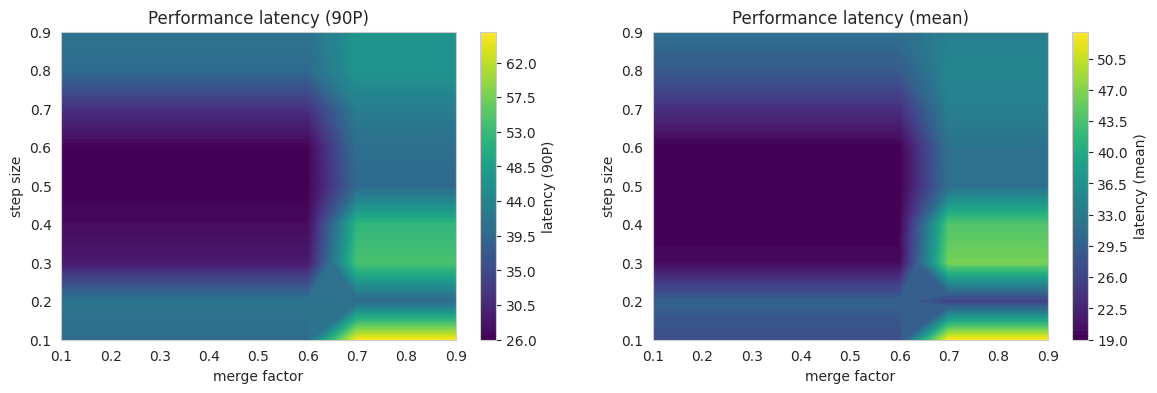

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value, ignoring nans
    min_index = np.unravel_index(np.nanargmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.savefig(f"plots/fit/nemop_params_sl_{slot_col}_w_{weight_col}.svg", bbox_inches="tight")
plt.show()

In [30]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
    "weight_2": {"merge_factor": 0.1, "step_size": 0.9},
    "weight": {"merge_factor": 0.1, "step_size": 0.5}
}

In [31]:
# for the eval for weights regarding latency
weight_cols = ["weight_2", "weight"]
for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"], weight_col, 
                                                                           merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.9, merge_factor=0.1
Level 0 CH number:  432 Load: 864
--------Balancing load for 3 clusters to 0
Level 1 CH number:  23 Load: 46
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.9, merge_factor=0.1
Level 0 CH number:  432 Load: 864
--------Balancing load for 3 clusters to 0
Level 1 CH number:  18 Load: 36
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.5, merge_factor=0.1
Level 0 CH number:  432 Load: 3088
--------Balancing load for 3 clusters to 0
Level 1 CH number:  70 Load: 537
--------Balancing load for 1 clusters to 0
Level 2 CH number:  13 Load: 88
--------Balancing load for 1 clusters to 0
Level 3 CH number:  2 Load: 8
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.5, merge_factor=0.1
Level 0 CH number:  432 Load: 3088
--------Balancing load for 3 clusters to 0
Level 1 CH number:  48 Load: 40

In [32]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.8, merge_factor=0.1
Level 0 CH number:  432 Load: 432
--------Balancing load for 3 clusters to 0
Level 1 CH number:  12 Load: 12
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  432 Load: 432
--------Balancing load for 3 clusters to 0
Level 1 CH number:  12 Load: 12
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  432 Load: 432
--------Balancing load for 3 clusters to 0
Level 1 CH number:  12 Load: 12
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  432 Load: 432
--------Balancing load for 3 clusters to 0
Level 1 CH number:  12 Load: 12
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  432 Load: 432
--------Balancing load for 

In [33]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,4.56190,6.84360,coordinator,-1,<NA>,<NA>,<NA>,50,38,2,<NA>,12
1,1,-4.17850,-6.91490,worker,0,1,0,1,50,50,0,39,0
2,2,-1.26250,-2.25620,worker,0,1,0,1,50,50,0,128,0
3,3,-0.14588,-2.82470,worker,0,1,0,1,50,50,0,128,0
4,4,6.22700,-0.84394,worker,0,1,0,1,50,50,0,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,428,14.10200,-4.01350,worker,0,1,0,1,50,50,0,143,0
429,429,13.88500,-5.90200,worker,0,1,0,1,50,50,0,39,0
430,430,12.97500,-5.61380,worker,0,1,0,1,50,50,0,143,0
431,431,-8.41010,8.46420,worker,0,1,0,1,50,50,0,129,0


In [34]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load


In [35]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
39,39,5.2869,5.8755,worker,1,1,0,1,50,10,1,0,40
70,70,4.8370,8.4271,worker,1,1,0,1,50,10,1,0,40
78,78,5.4922,8.7727,worker,1,1,0,1,50,10,1,0,40
120,120,-226.6900,75.7340,worker,2,1,0,1,50,50,1,0,0
126,126,4.1122,6.7365,worker,1,1,0,1,50,10,1,0,40
128,128,5.5825,6.4770,worker,1,1,0,1,50,10,1,0,40
129,129,3.5262,7.5597,worker,1,1,0,1,50,10,1,0,40
137,137,3.4592,5.9184,worker,1,1,0,1,50,10,1,0,40
138,138,5.4727,7.8030,worker,1,1,0,1,50,10,1,0,40
140,140,4.5845,7.8056,worker,1,1,0,1,50,30,1,0,20


In [36]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [37]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [38]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,38,0,12,38
1,39,50,10,39,40,10
2,70,50,10,70,40,10
3,78,50,10,78,40,10
4,126,50,10,126,40,10
5,128,50,10,128,40,10
6,129,50,10,129,40,10
7,137,50,10,137,40,10
8,138,50,10,138,40,10
9,140,50,30,140,20,30


In [39]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

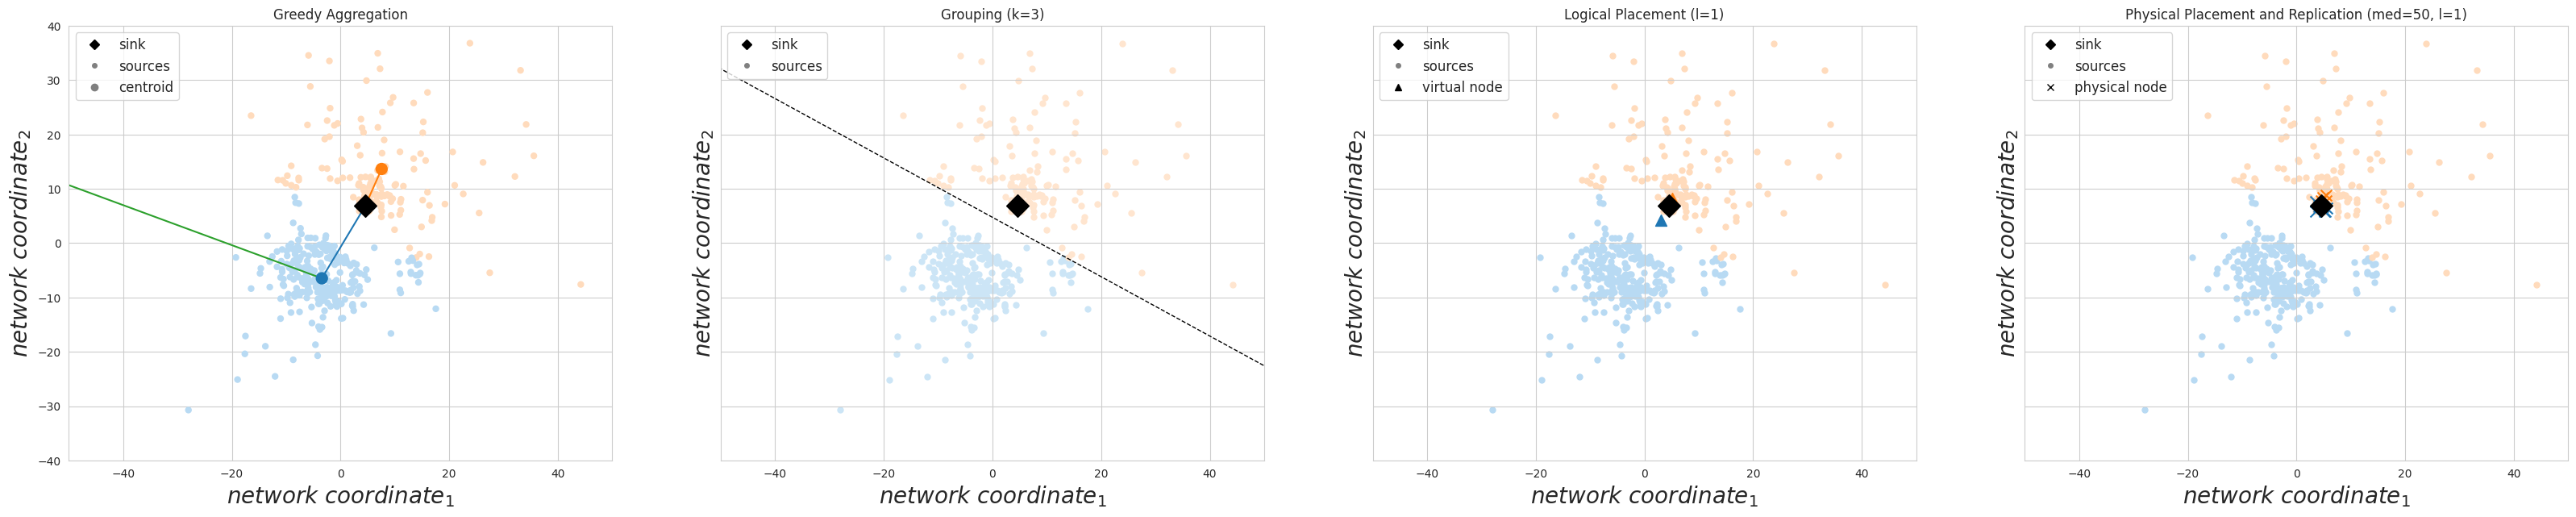

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/fit/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.9, merge_factor=0.1
Level 0 CH number:  432 Load: 864
--------Balancing load for 3 clusters to 0
Level 1 CH number:  20 Load: 40
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.9, merge_factor=0.1
Level 0 CH number:  432 Load: 864
--------Balancing load for 3 clusters to 0
Level 1 CH number:  20 Load: 40
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.9, merge_factor=0.1
Level 0 CH number:  432 Load: 864
--------Balancing load for 3 clusters to 0
Level 1 CH number:  20 Load: 40


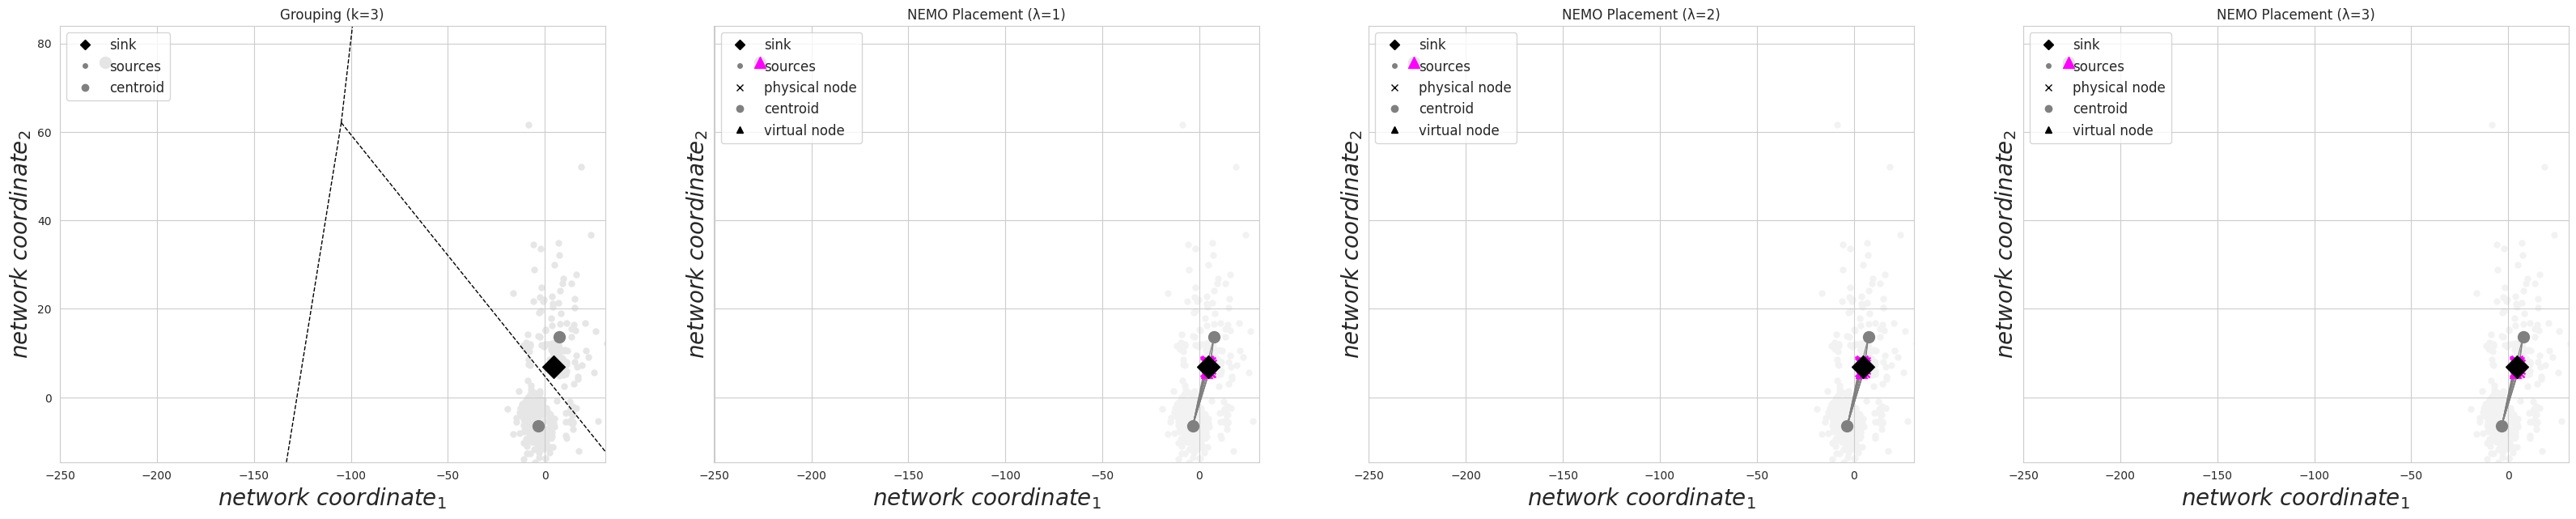

In [43]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)
    
    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i+1].set_title(f"NEMO Placement (λ={str(level)})")

plt.show()

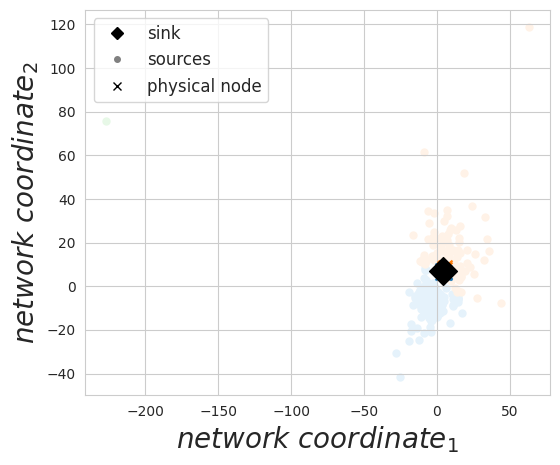

In [44]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/fit/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  2.7714 %


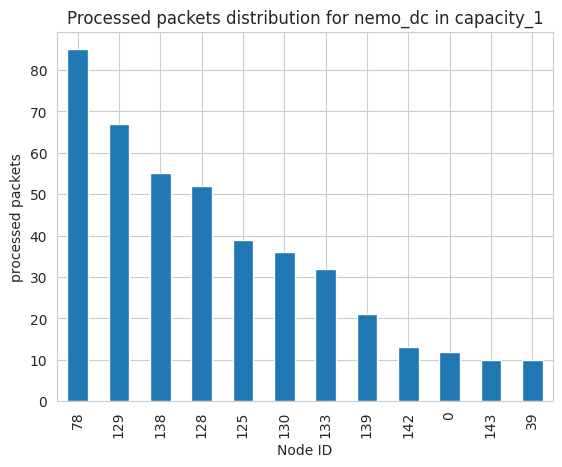

In [45]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [46]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:4742.0, valueBest:4610.0
i:10, t(i):3.49, valueNow:4131.0, valueBest:4129.0
i:20, t(i):1.22, valueNow:3528.0, valueBest:3523.0
i:30, t(i):0.42, valueNow:3038.0, valueBest:3038.0
i:40, t(i):0.15, valueNow:2849.0, valueBest:2849.0
i:50, t(i):0.05, valueNow:2751.0, valueBest:2751.0
i:60, t(i):0.02, valueNow:2671.0, valueBest:2671.0


In [47]:
print(route)

[333 368 369 292 267 380 251   1 303 257 366  39  95 138 394 148 212 318
 265 196 211 146 236 208 235 200 150 231 340 198 188 204 155 210 215 221
 197 147 167 163 227 160 313 423 403 427 294 238 314 347 278 321 179 289
 164 260 308 299 291 276 339 207 311 168 156 165 388 386 358 346 209 175
 277 392 373 309 290 414 320 183 152 202 185 259 172 214 189 245 217 171
 312 169 302 220 266 213 284 323 222 195 191 402 419 432 410  18  14  28
   7  47 112 140 133 139 137 379 345 390 343 361 389 393   6  97  33  16
 415 430 412   4 128  78  60 401 431 115 141 130 104  26 125 127 131 411
 418 417 136   5  41  92  46  64  87  80 123 118  13  76  65  50  37  79
  83  93  52 100  36  96  38  90  22 107  99  34  61 129 348 382 374 375
 341 364 413 106  54 116  73  85  42  59  43 111  25  49 105  55  44  31
  19  11  24  21 114  23 132  84  75  69   8  68 119  71  58  17  66 135
  10  30 426 407 428  94  27  81  32  20  12  77  89  35 124 101  67 113
 117  63  56 102  91 103 356 326 250 184 170 288 29

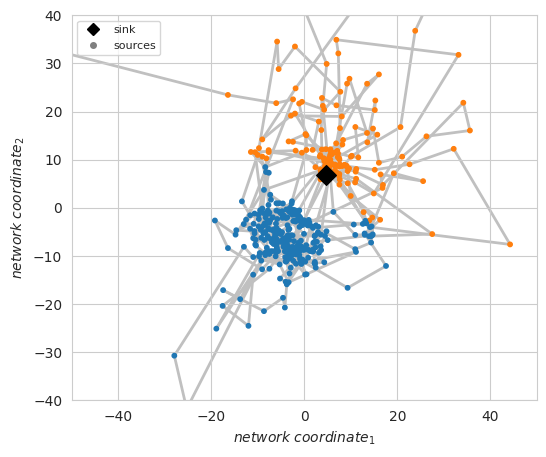

In [48]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/fit/chain_50n.svg", bbox_inches="tight")
plt.show()

In [49]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  340  in route.


In [50]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
428    1.0
429    1.0
430    1.0
431    1.0
432    1.0
Name: received_packets, Length: 433, dtype: float64


count     433.000000
mean     1087.616405
std       839.929680
min         0.000000
25%       194.681208
50%      1285.119407
75%      1892.310569
max      2373.966525
Name: latency_distribution, dtype: float64


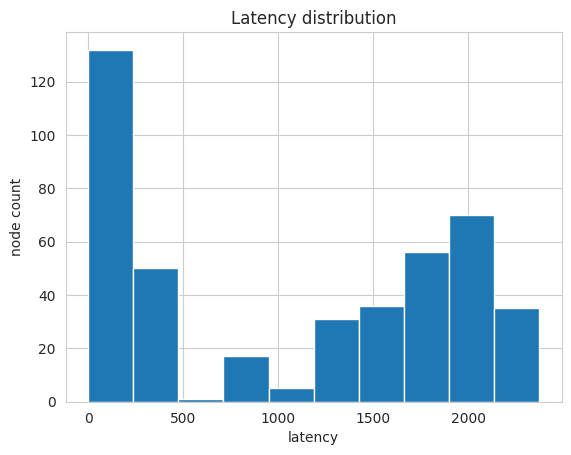

In [51]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    433.000000
mean       0.997691
std        0.083301
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


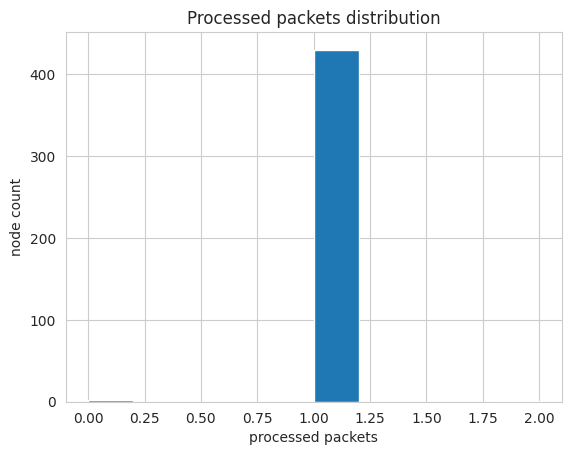

In [52]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [53]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [54]:
df = prim_df.copy()
mst = prim_mst(coords)

In [55]:
print(mst)

[-1, 206, 400, 345, 384, 112, 90, 112, 34, 68, 130, 53, 7, 9, 21, 33, 97, 66, 21, 6, 12, 88, 61, 95, 45, 60, 72, 36, 14, 78, 24, 38, 14, 81, 91, 31, 89, 93, 96, 128, 55, 49, 65, 51, 55, 114, 93, 107, 85, 99, 63, 110, 32, 28, 67, 75, 102, 59, 59, 42, 115, 104, 26, 105, 105, 48, 108, 57, 123, 64, 134, 85, 70, 50, 132, 84, 71, 80, 70, 37, 88, 16, 78, 69, 73, 50, 11, 77, 20, 46, 97, 49, 41, 69, 15, 74, 27, 32, 57, 103, 81, 35, 79, 118, 82, 8, 54, 92, 62, 22, 119, 25, 95, 413, 23, 110, 106, 58, 109, 17, 122, 106, 98, 103, 101, 130, 0, 125, 143, 125, 139, 30, 82, 0, 127, 141, 128, 126, 136, 133, 10, 129, 39, 0, 288, 165, 271, 201, 174, 198, 208, 185, 298, 178, 291, 170, 173, 148, 194, 302, 259, 285, 177, 166, 249, 253, 156, 193, 311, 211, 161, 147, 322, 322, 334, 284, 316, 328, 157, 289, 269, 196, 242, 320, 313, 152, 195, 266, 236, 214, 250, 299, 317, 227, 313, 220, 265, 217, 189, 218, 205, 167, 184, 183, 208, 224, 180, 306, 235, 254, 200, 338, 312, 229, 213, 210, 205, 171, 150, 149, 146, 33

In [56]:
routes = createRoutes(mst)
print(routes[3])

[345, 389, 382, 392, 2, 400, 390, 349, 343, 348, 374, 361, 397, 363, 352, 362, 310, 287, 360, 296, 314, 256, 282, 283, 190, 250, 293, 301, 326, 275, 290, 364, 341, 286, 406, 414, 431, 423, 425, 421, 111, 25, 60, 115, 110, 119, 17, 66, 108, 62, 26, 72, 70, 134, 127, 125, 130, 139, 133, 0]


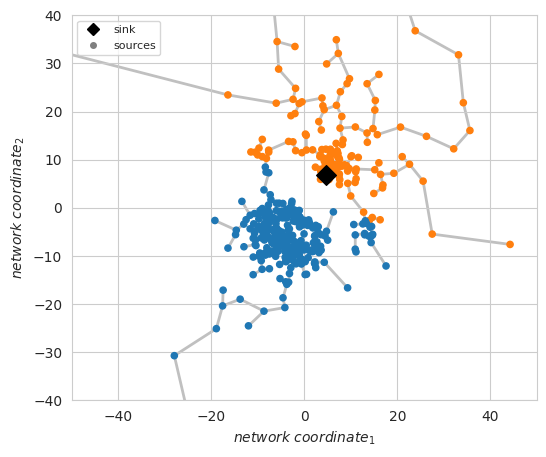

In [57]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/fit/mst.svg", bbox_inches="tight")
plt.show()

In [58]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    433.000000
mean      37.461694
std       22.744198
min        0.000000
25%       23.050038
50%       43.481998
75%       49.674333
max      261.640555
Name: latency_distribution, dtype: float64


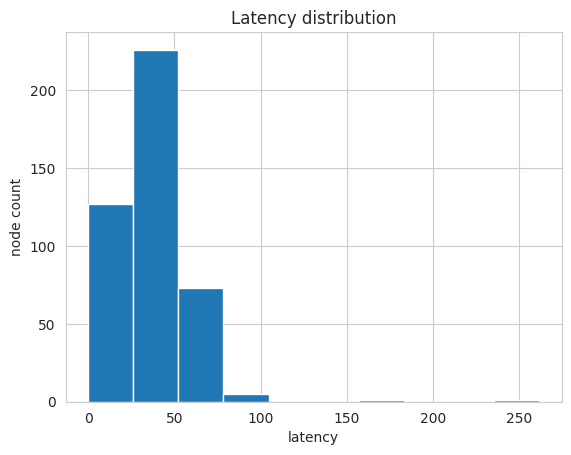

In [59]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  79.2148 %


Text(0.5, 1.0, 'Processed packets distribution')

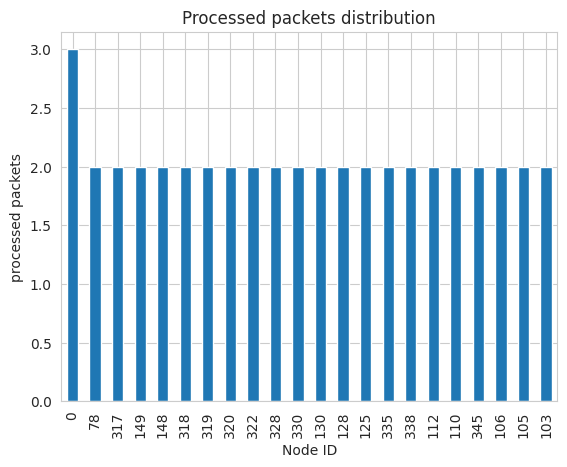

In [60]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [61]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [62]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst'])

In [63]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [64]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [65]:
heterogen_appr

['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [66]:
ecolors, elight_colors, epalette = util.get_color_list(20)

eval_colors = {
    "dt": ecolors[0],
    "leach": ecolors[1],
    "mst": ecolors[2],
    "chain": ecolors[3],
    "nemo": ecolors[4],
    "nemo_base": ecolors[4],
    "nemo_dc_base": ecolors[4],
    "NEMO_base": ecolors[4],
    "nemo_rc": ecolors[5],
    "nemo_rc_base": ecolors[5],
    "nemo (rdm groups)_base": ecolors[5],
    "nemo_dc": ecolors[6],
    "NEMO+redistribution": ecolors[6],
    "nemo_pen": ecolors[7],
    "nemo_pen_base": ecolors[8],
    "nemo_dc_weight_2": ecolors[9],
    "nemo_dc_weight": ecolors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}


In [67]:
eval_matrix["dt"]["latency_distribution"].mean()

15.494777665579779

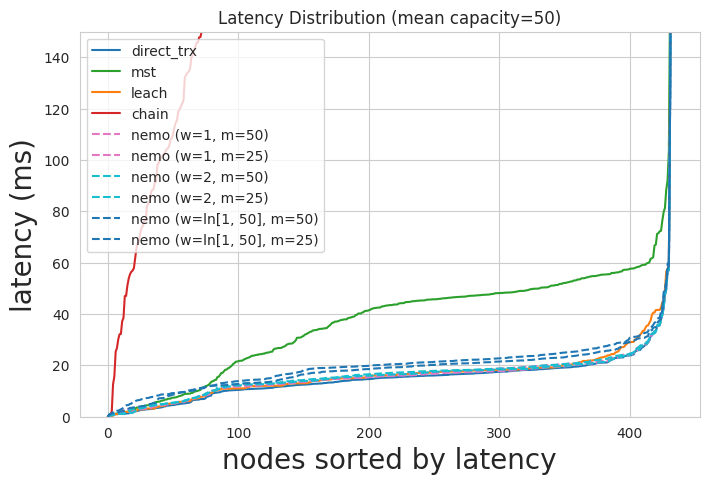

Means:  {'dt': 15.49, 'mst': 37.46, 'leach': 16.81, 'chain': 1087.62, 'nemo (w=1, m=50)': 16.15, 'nemo (w=1, m=25)': 16.59, 'nemo (w=2, m=50)': 16.45, 'nemo (w=2, m=25)': 16.9, 'nemo (w=ln[1, 50], m=50)': 19.01, 'nemo (w=ln[1, 50], m=25)': 20.31}
Quantiles:  {'dt': 22.87, 'mst': 56.12, 'leach': 24.89, 'chain': 2106.6, 'nemo (w=1, m=50)': 22.94, 'nemo (w=1, m=25)': 23.02, 'nemo (w=2, m=50)': 22.96, 'nemo (w=2, m=25)': 23.52, 'nemo (w=ln[1, 50], m=50)': 26.14, 'nemo (w=ln[1, 50], m=25)': 28.27}


In [68]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"
            
        sv = df["latency_distribution"].sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/fit/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [69]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [70]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'chain', 'mst'])

In [71]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [72]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.35, 0.45, 4.0, 9.65],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]}

In [73]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [74]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

In [75]:
agg_arr1 = []
for fam in eval_matrix_load.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.35, 0.45, 4.0, 9.65]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]


dt [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
leach [0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.35, 0.45, 4.0, 9.65]
chain [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29]
mst [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]
nemo_dc [50. 51. 51. 50. 49. 49. 47. 43. 41. 36. 29. 23.]
nemo_dc [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


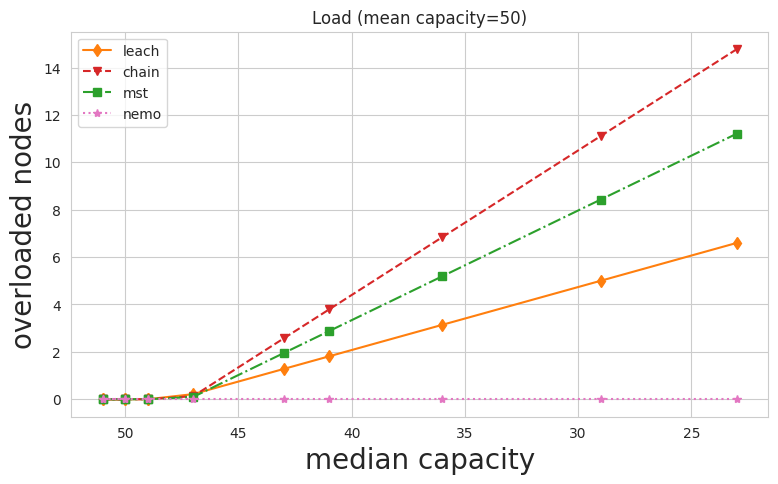

In [76]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/fit/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


In [77]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

leach - d #ff7f0e : [0.0, 0.0, 0.0, 0.0, 0.11627906976744186, 0.11627906976744186, 0.0, 0.0, 0.813953488372093, 1.0465116279069768, 9.30232558139535, 22.44186046511628]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.728538283062645]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.185185185185185]
nemo : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


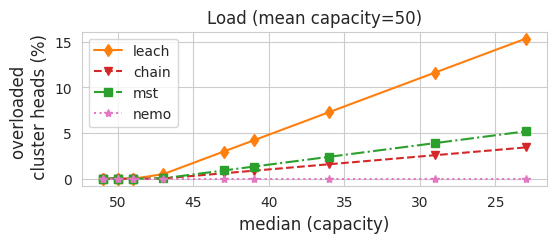

In [78]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/fit/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [79]:
quant_dict

{'dt': 22.87,
 'mst': 56.12,
 'leach': 24.89,
 'chain': 2106.6,
 'nemo (w=1, m=50)': 22.94,
 'nemo (w=1, m=25)': 23.02,
 'nemo (w=2, m=50)': 22.96,
 'nemo (w=2, m=25)': 23.52,
 'nemo (w=ln[1, 50], m=50)': 26.14,
 'nemo (w=ln[1, 50], m=25)': 28.27}

In [80]:
mean_dict

{'dt': 15.49,
 'mst': 37.46,
 'leach': 16.81,
 'chain': 1087.62,
 'nemo (w=1, m=50)': 16.15,
 'nemo (w=1, m=25)': 16.59,
 'nemo (w=2, m=50)': 16.45,
 'nemo (w=2, m=25)': 16.9,
 'nemo (w=ln[1, 50], m=50)': 19.01,
 'nemo (w=ln[1, 50], m=25)': 20.31}